In [175]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob

In [106]:
def eofs_GA(inxarr, variables=['u','v'], time_name='ocean_time', treshold=None):
    tmp=inxarr[['u','v']]
    tmp=tmp.to_stacked_array('z_loc',sample_dims=[time_name])
    solver = Eof(tmp)

    out=xr.Dataset()
    out['lon']=inxarr['lon']
    out['lat']=inxarr['lat']
    out['z']=inxarr['z']
    out['eigenvals']=solver.eigenvalues()

    #if treshold < lmbda.mode.max(): 
    #    np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]
    eofs=solver.eofs(neofs=5).to_unstacked_dataset('z_loc').unstack()
    out['eofs_u']=eofs['u']
    out['eofs_v']=eofs['v']
    out['eofs_speed']=np.sqrt(out.eofs_u**2+out.eofs_v**2)
    angles=np.arctan2(out['eofs_u'],out['eofs_v'])
    out['eofs_direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    out['pcs']=solver.pcs(npcs=5)

    return out

    

In [190]:
def plot_eofs(res,name='',save_dir='',save=False):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.7)
    fig.suptitle("Eofs" + name, fontsize=18, y=0.95)
    axes=axs.ravel()
    res.pcs.isel(mode=[0,1,2,3]).plot.line(x='ocean_time',ax=axes[0])
    (res.eigenvals[0:10].cumsum()/res.eigenvals.sum()).plot(marker='x',ax=axes[1])
    res.eigenvals[0:10].plot(marker='o',color='r',ax=axes[1].twinx())
    
    for mode in np.arange(4):
        res.isel(mode=mode,depth=1).plot.quiver(x='lon',y='lat' ,u='eofs_u', v='eofs_v',hue='eofs_speed',ax=axes[mode+2])

    if save:
        plt.savefig(save_dir+name+'.jpg')

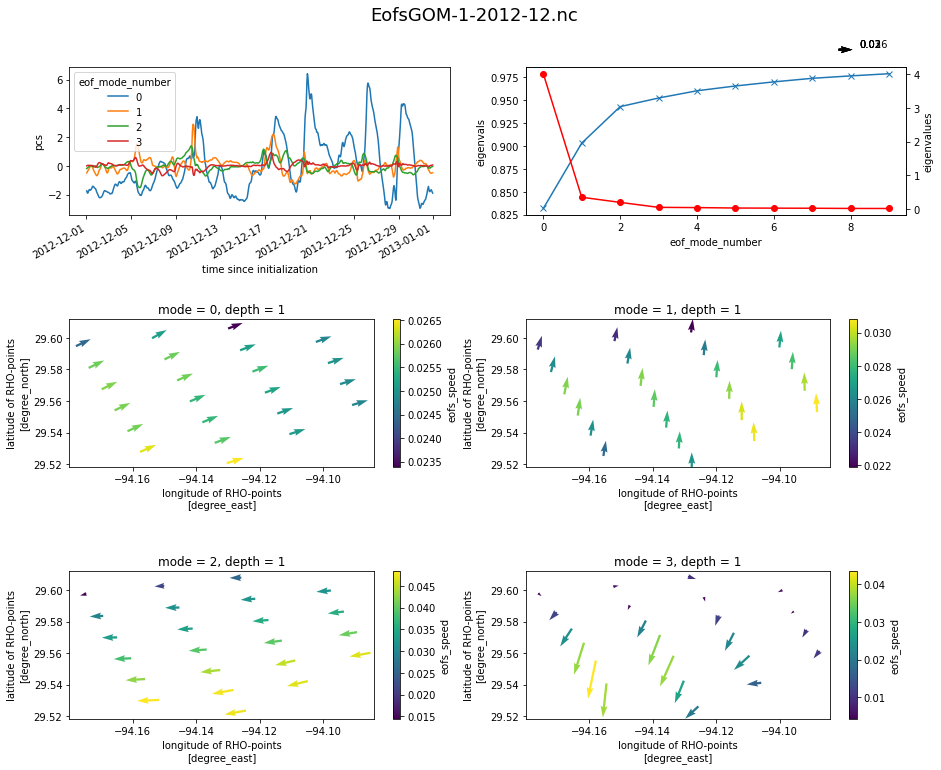

In [191]:
plot_eofs(res, name=name, save_dir='Fig_new_5km-radius/',save=False)

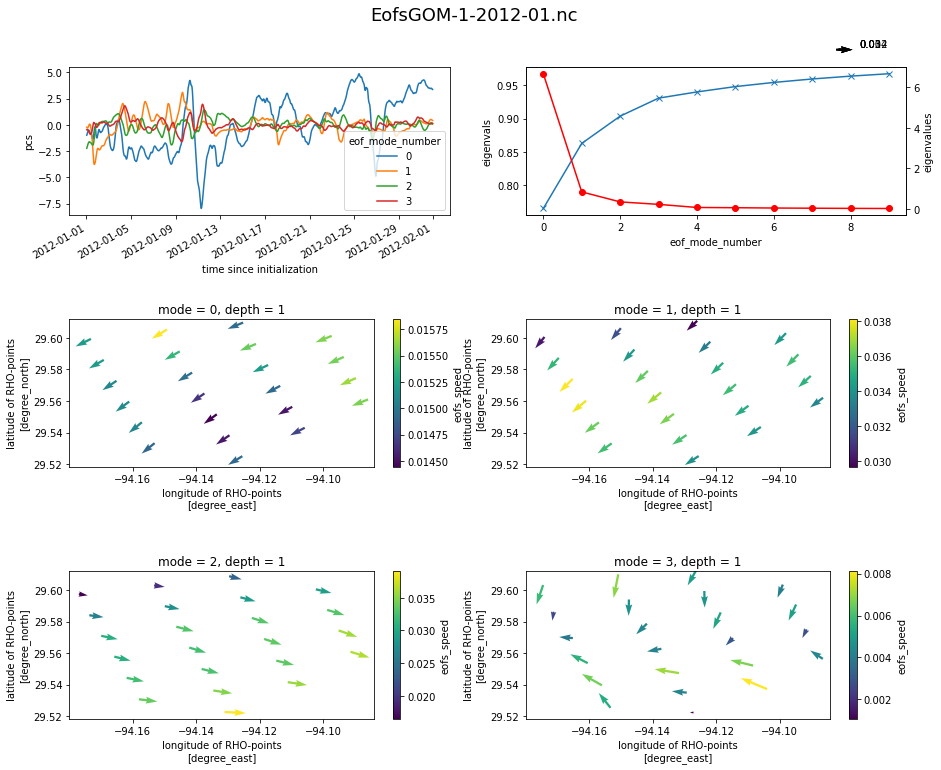

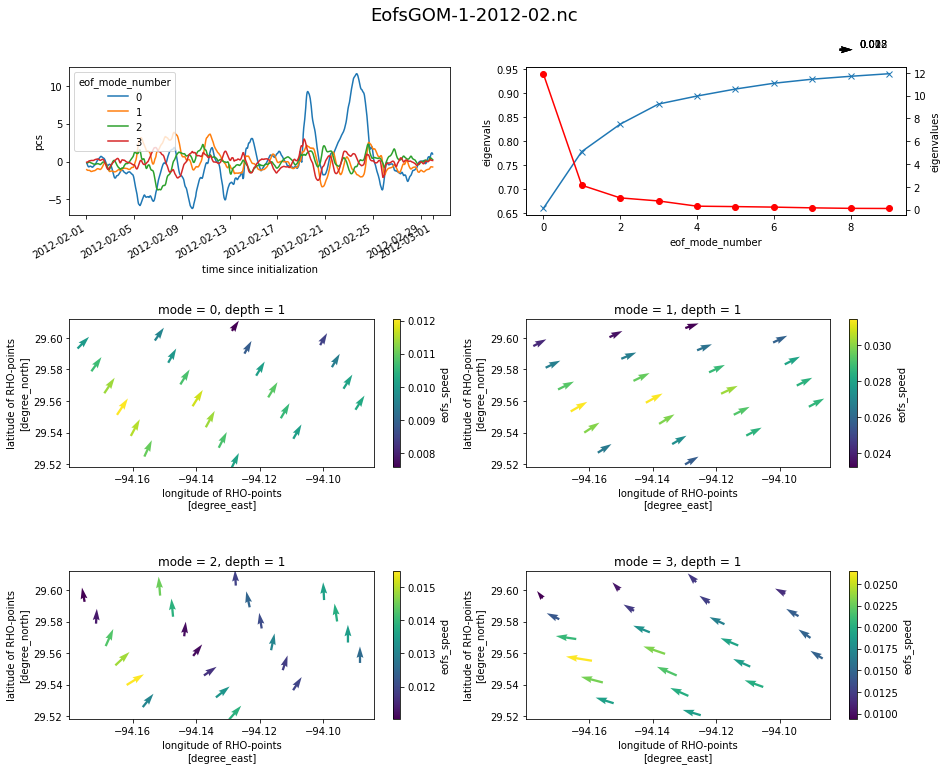

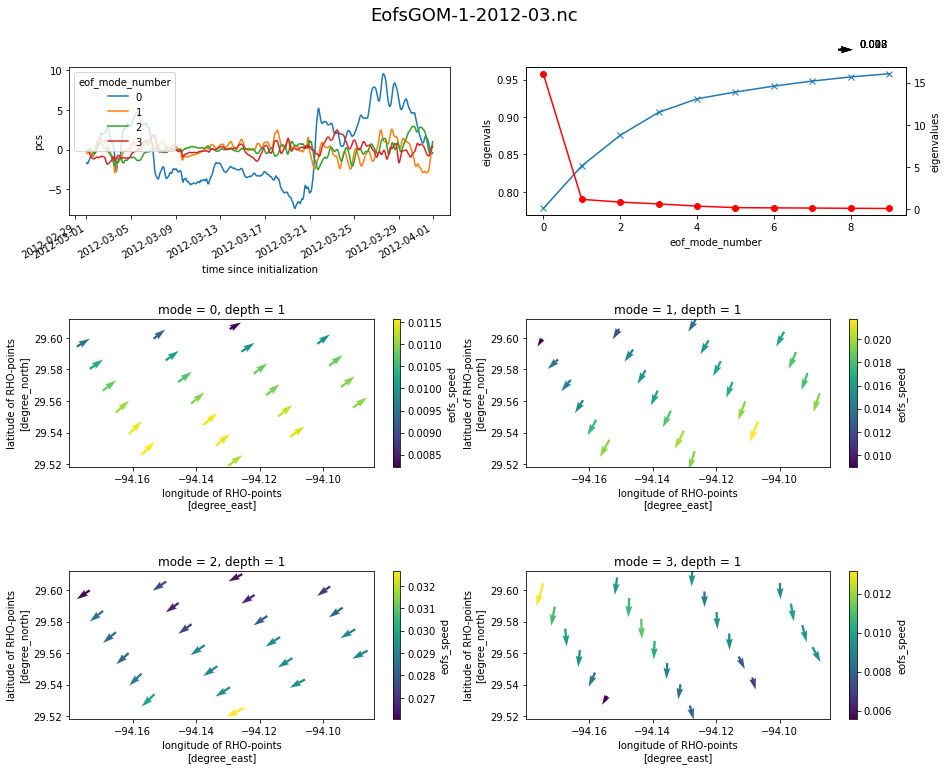

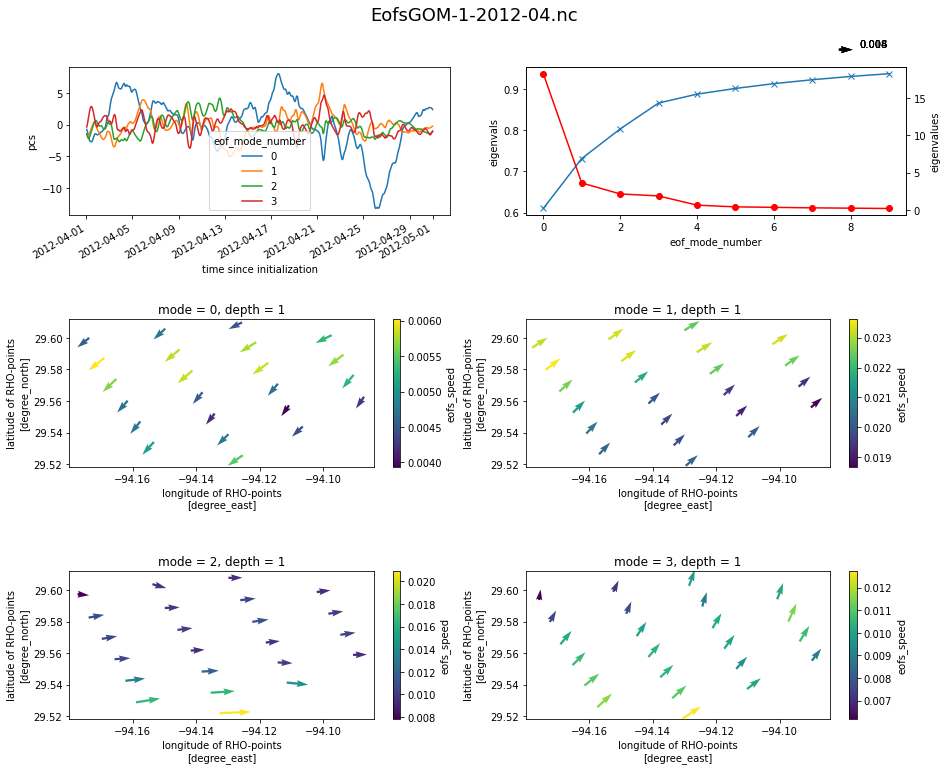

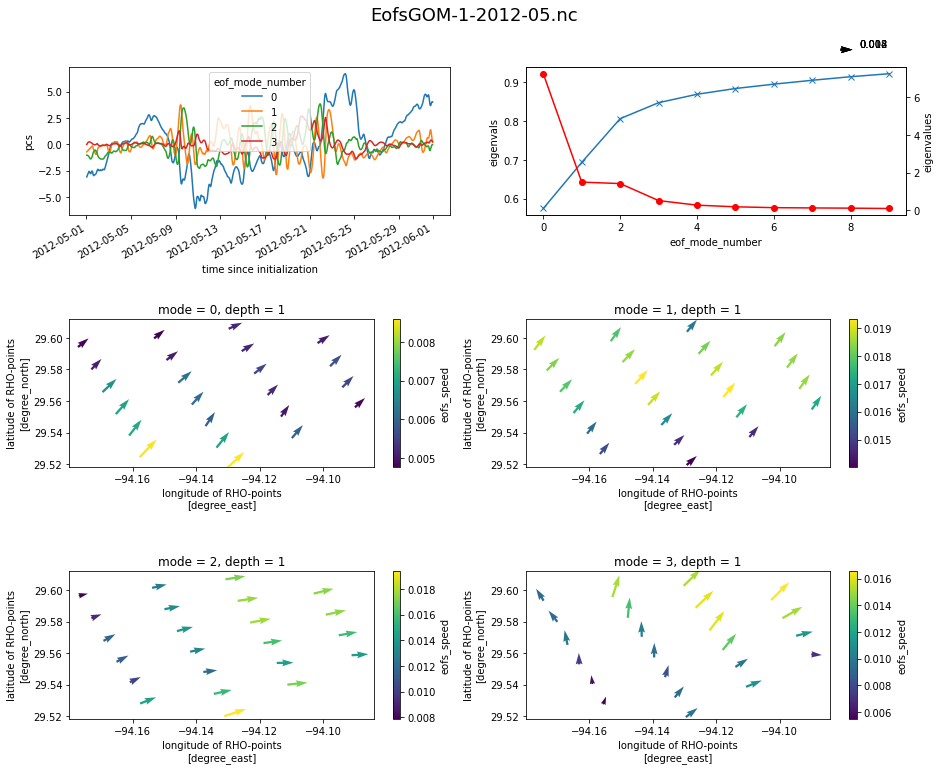

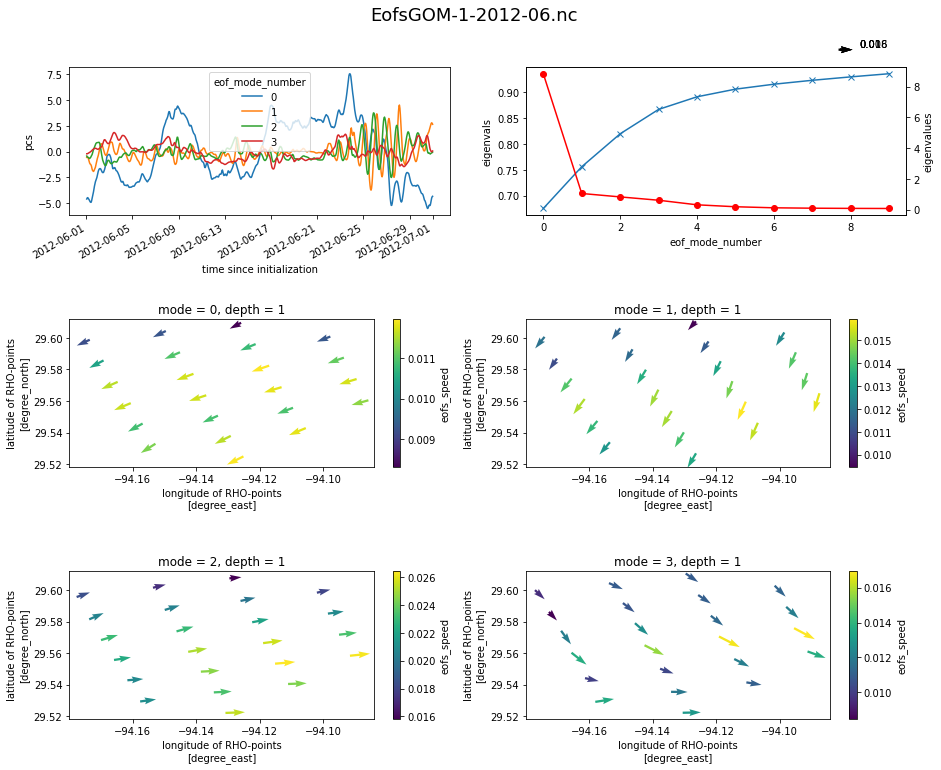

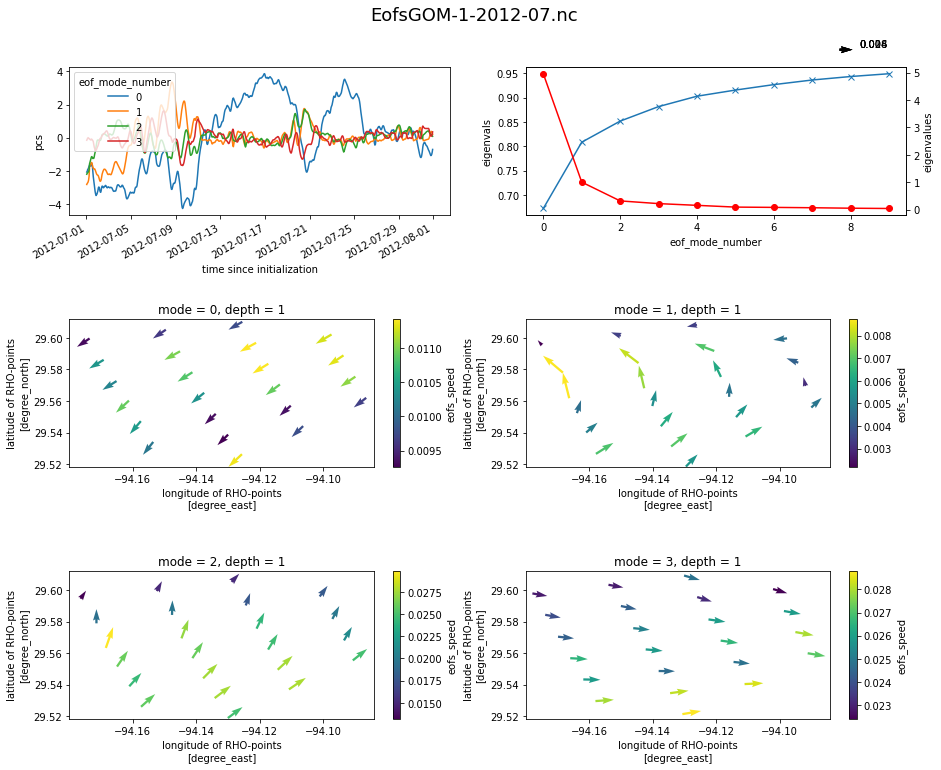

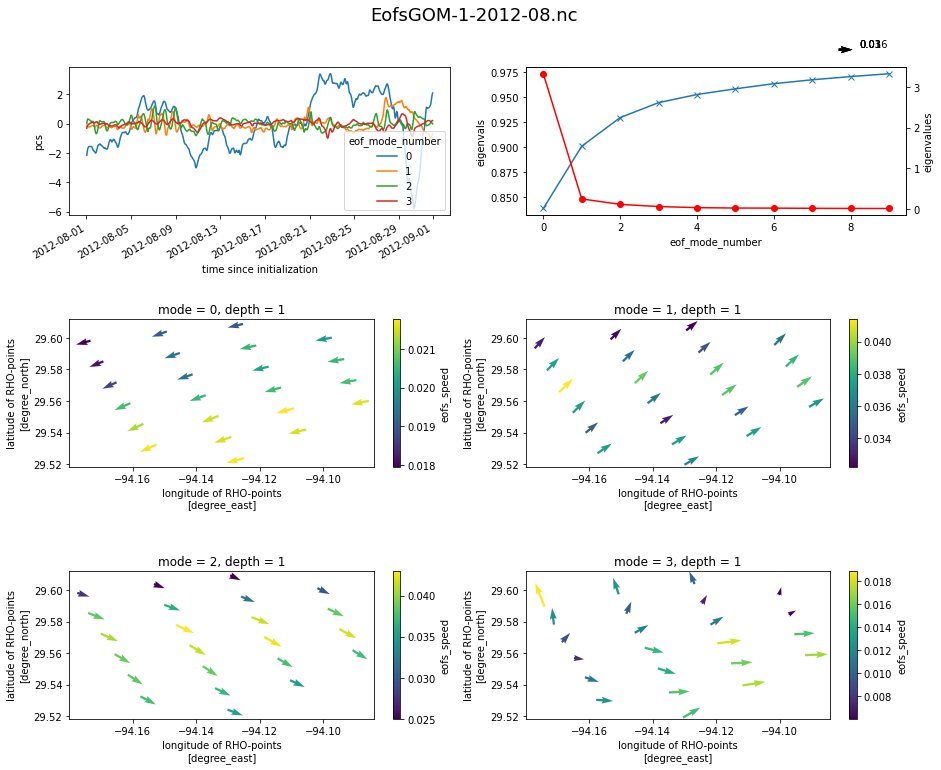

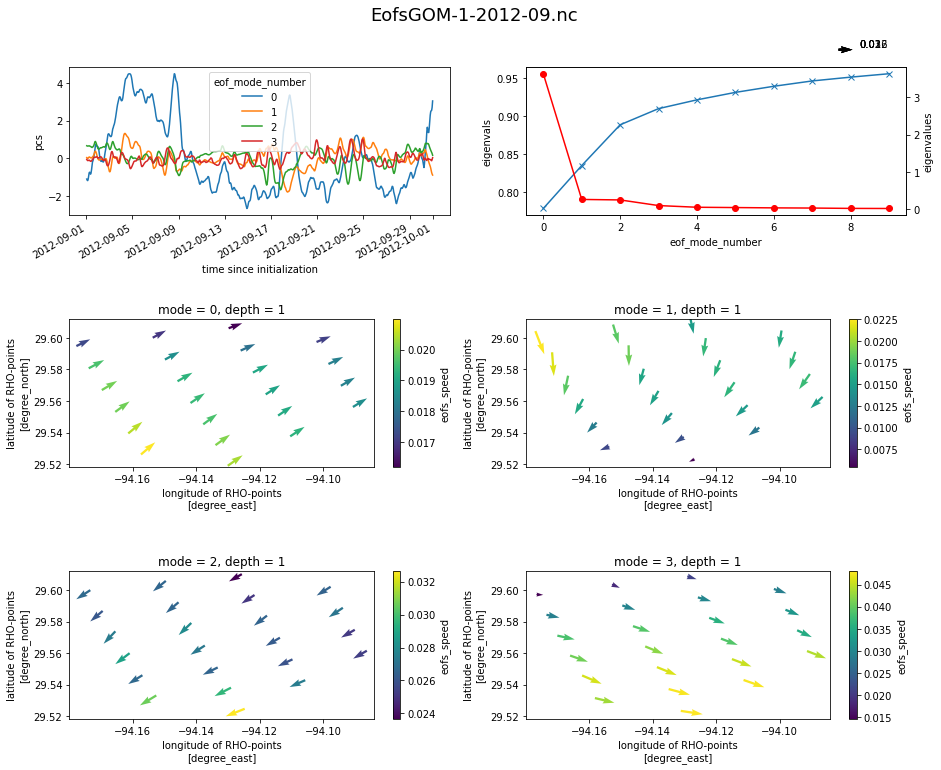

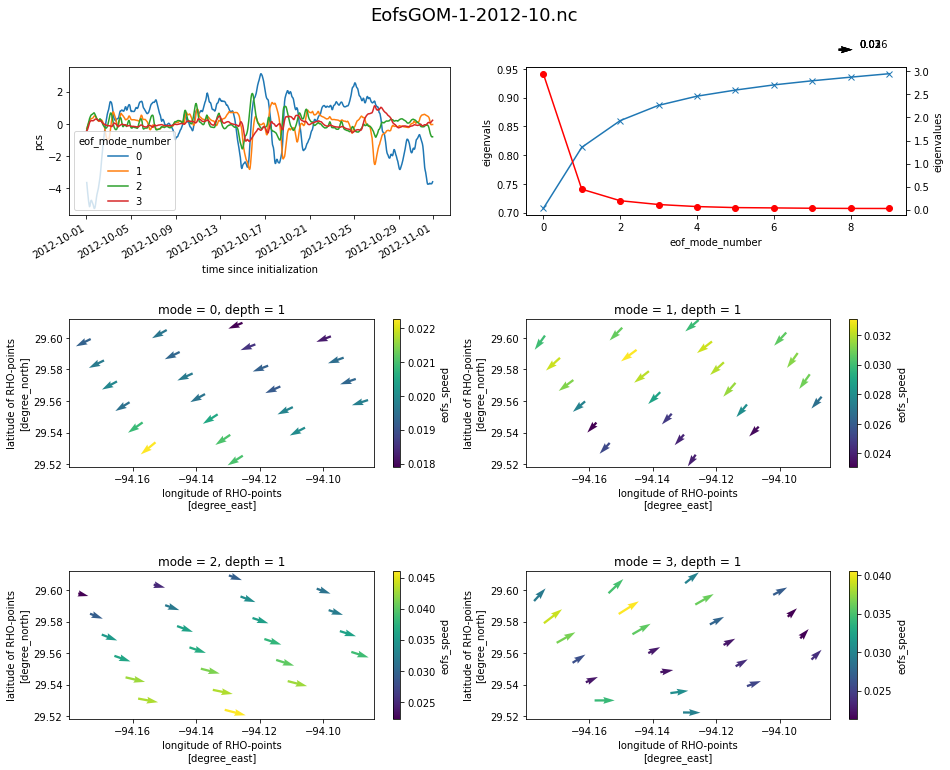

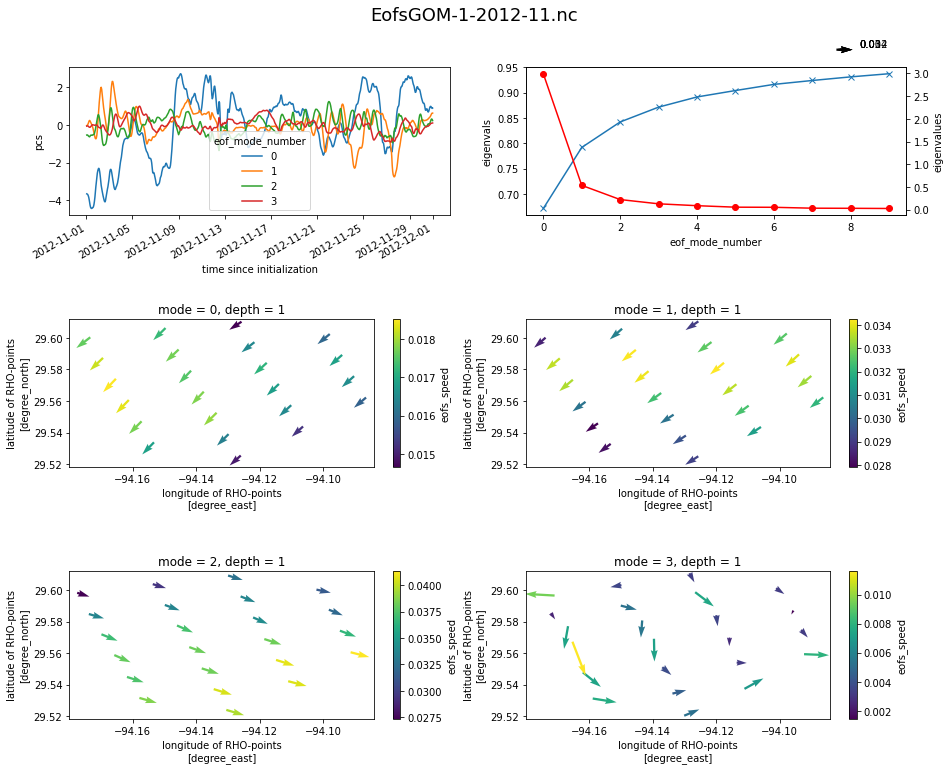

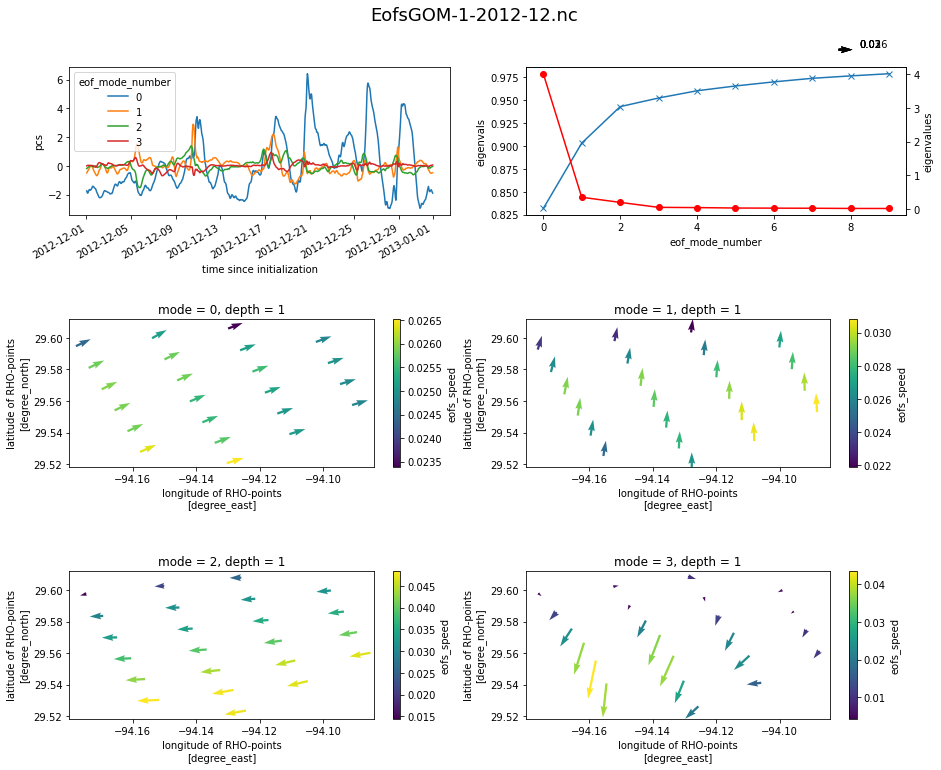

In [192]:
files=glob.glob('new_5km-radius/GOM-1-*2012*')
for file in files:
    name=file.split('/')[1]
    vel=xr.open_dataset(file).load()
    vel.close()
    res=eofs_GA(vel)
    plot_eofs(res, name=name, save_dir='Fig_new_5km-radius/',save=True)

In [200]:
files

['new_5km-radius/GOM-1-2012-01.nc',
 'new_5km-radius/GOM-1-2012-02.nc',
 'new_5km-radius/GOM-1-2012-03.nc',
 'new_5km-radius/GOM-1-2012-04.nc',
 'new_5km-radius/GOM-1-2012-05.nc',
 'new_5km-radius/GOM-1-2012-06.nc',
 'new_5km-radius/GOM-1-2012-07.nc',
 'new_5km-radius/GOM-1-2012-08.nc',
 'new_5km-radius/GOM-1-2012-09.nc',
 'new_5km-radius/GOM-1-2012-10.nc',
 'new_5km-radius/GOM-1-2012-11.nc',
 'new_5km-radius/GOM-1-2012-12.nc']

In [238]:
data=[]
for file in files:
    data.append(xr.open_dataset(file))

data=xr.concat(data,dim='ocean_time')

In [243]:
tmp=xr.open_dataset(files[0])
data=data.drop(['lon','lat','z'])
data['lon']=tmp['lon']
data['lat']=tmp['lat']
data['z']=tmp['z']
data

<xarray.Dataset>
Dimensions:     (ocean_time: 8784, depth: 30, node: 23)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01T01:00:00 ... 2013-01-01
Dimensions without coordinates: depth, node
Data variables:
    temp        (ocean_time, depth, node) float64 16.57 16.58 ... 14.47 14.48
    salt        (ocean_time, depth, node) float64 29.19 29.36 ... 30.6 30.57
    w           (ocean_time, depth, node) float64 4.346e-06 ... 3.179e-07
    u           (ocean_time, depth, node) float64 -0.006107 ... -0.0975
    v           (ocean_time, depth, node) float64 0.004908 0.01094 ... 0.05773
    lon         (node) float64 ...
    lat         (node) float64 ...
    z           (depth, node) float64 ...
Attributes: (12/33)
    file:              /scratch/user/d.kobashi/projects/hindcasts/projects/tx...
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Texas-Louisiana shelf hindcast with dyes
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model fast -heap-arrays -ip -O3
    tiling:            010x012
    ana_file:          /scratch/user/d.kobashi/source_code/COAWST/Functionals...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFLUX,...
    history:           Sun Feb 20 15:39:41 2022: ncrename -v depth,z 5km-radi...
    NCO:               netCDF Operators version 5.0.6 (Homepage = http://nco....

In [277]:
data.u.max()

<xarray.DataArray 'u' ()>
array(0.87542225)

In [244]:
res=eofs_GA(data)


In [281]:
res.ocean_time.diff(dim='ocean_time').min()/res.ocean_time.diff(dim='ocean_time').max()

<xarray.DataArray 'ocean_time' ()>
array(1.)

In [269]:
res.pcs[0]

<xarray.DataArray 'pcs' (mode: 1380)>
array([ 2.20126998, -0.1288768 , -2.01211462, ...,         nan,
               nan,         nan])
Coordinates:
  * mode        (mode) int64 0 1 2 3 4 5 6 ... 1374 1375 1376 1377 1378 1379
    ocean_time  datetime64[ns] 2012-01-01T01:00:00

In [264]:
res.isel(mode=7,depth=1)['eofs_v']
#print(res.isel(mode=0,depth=2).max())

<xarray.DataArray 'eofs_v' (node: 23)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    mode     int64 7
    depth    int64 1
  * node     (node) int64 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21 22
Attributes:
    long_name:  empirical_orthogonal_functions

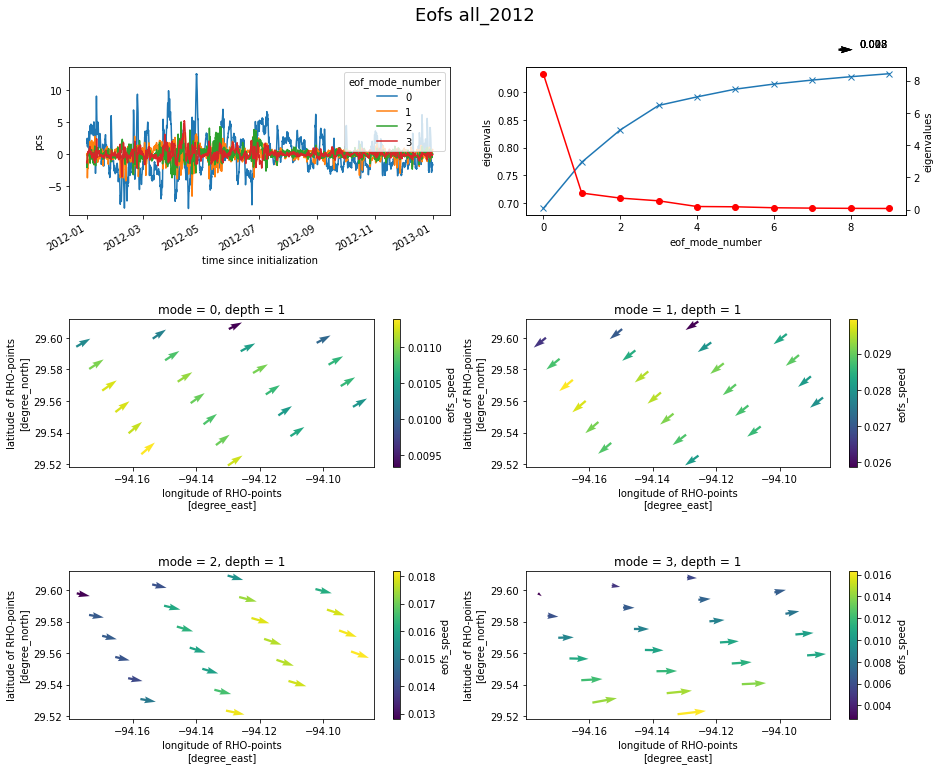

In [250]:
plot_eofs(res, name=' all_2012', save_dir='Fig_new_5km-radius/',save=True)

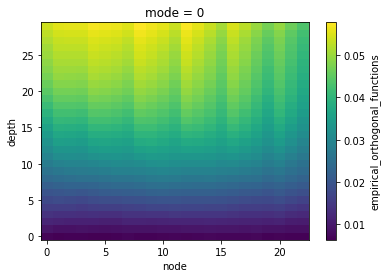

In [215]:
res.eofs_u.isel(mode=0).plot()


In [131]:
lmbda.mode.max()

<xarray.DataArray 'mode' ()>
array(193)

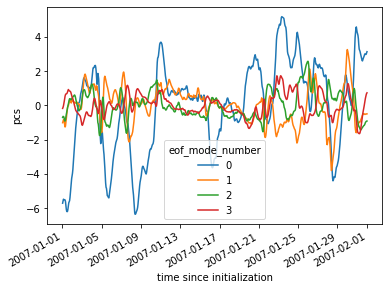

In [156]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='ocean_time')

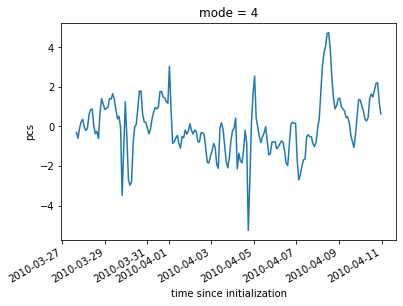

In [117]:
pcs.isel(mode=4).plot.line(x='time')

In [108]:
np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]


24

In [109]:
lmbda.cumsum()/lmbda.sum()

<xarray.DataArray 'eigenvalues' (mode: 194)>
array([0.2926029 , 0.50760263, 0.6704176 , 0.72706103, 0.75046474,
       0.7697846 , 0.7839178 , 0.79780746, 0.80876976, 0.8180657 ,
       0.82695293, 0.83540136, 0.84304786, 0.8500836 , 0.8567792 ,
       0.86313224, 0.868865  , 0.874107  , 0.87890154, 0.88358384,
       0.88786507, 0.8919848 , 0.8957996 , 0.899477  , 0.902951  ,
       0.9059057 , 0.9087735 , 0.9115133 , 0.9142091 , 0.9167508 ,
       0.9191664 , 0.92154104, 0.9238738 , 0.9261053 , 0.9282357 ,
       0.9302513 , 0.93219054, 0.93401724, 0.9358111 , 0.9375409 ,
       0.9392072 , 0.9408232 , 0.9423908 , 0.94385815, 0.94527644,
       0.9466451 , 0.9479504 , 0.9491875 , 0.95038444, 0.9515679 ,
       0.9527387 , 0.9538961 , 0.95499766, 0.95606965, 0.95711887,
       0.9581198 , 0.9590963 , 0.9600636 , 0.96100944, 0.9619003 ,
       0.96278083, 0.9636419 , 0.9644665 , 0.9652764 , 0.966073  ,
       0.96684664, 0.9676163 , 0.9683468 , 0.96906346, 0.96975535,
       0.97043455, 0.97110647, 0.97175336, 0.97239476, 0.97302496,
       0.9736244 , 0.97421026, 0.97478837, 0.97536284, 0.9759252 ,
       0.9764777 , 0.97700185, 0.97751945, 0.9780304 , 0.97852635,
       0.9790085 , 0.97948766, 0.97995496, 0.9804083 , 0.9808485 ,
       0.98128647, 0.98171484, 0.9821294 , 0.98253256, 0.98292917,
       0.98331535, 0.9836971 , 0.9840737 , 0.98444635, 0.98480463,
       0.98515797, 0.98551035, 0.9858467 , 0.9861784 , 0.98650175,
       0.9868243 , 0.9871451 , 0.9874587 , 0.9877584 , 0.98805404,
       0.98834306, 0.9886279 , 0.9889037 , 0.9891766 , 0.9894454 ,
       0.98971033, 0.9899698 , 0.9902234 , 0.9904721 , 0.9907151 ,
       0.9909561 , 0.9911879 , 0.9914141 , 0.99163604, 0.9918545 ,
       0.9920701 , 0.99228317, 0.9924925 , 0.9926989 , 0.99290335,
       0.9930982 , 0.99329066, 0.99348176, 0.993665  , 0.99384594,
       0.99402404, 0.99419963, 0.99437255, 0.99454325, 0.9947111 ,
       0.99487513, 0.9950368 , 0.9951947 , 0.99535125, 0.9955055 ,
       0.99565655, 0.9958045 , 0.9959483 , 0.99609005, 0.9962302 ,
       0.9963636 , 0.9964952 , 0.99662477, 0.99675226, 0.9968768 ,
       0.99699944, 0.9971194 , 0.9972366 , 0.9973518 , 0.9974647 ,
       0.99757373, 0.9976811 , 0.9977861 , 0.9978896 , 0.9979919 ,
       0.99808985, 0.998186  , 0.99828064, 0.99837375, 0.9984645 ,
       0.99855304, 0.99864006, 0.9987246 , 0.9988086 , 0.9988891 ,
       0.99896914, 0.99904686, 0.9991217 , 0.9991954 , 0.9992684 ,
       0.9993371 , 0.9994038 , 0.9994692 , 0.99953157, 0.99959177,
       0.9996487 , 0.9997046 , 0.99975854, 0.9998103 , 0.9998614 ,
       0.99991167, 0.9999577 , 1.0000001 , 1.0000001 ], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 ... 186 187 188 189 190 191 192 193

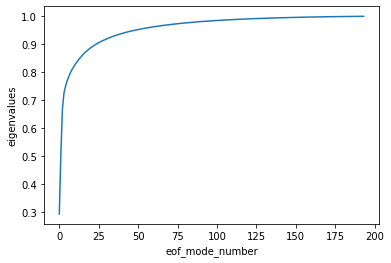

In [52]:
(solver.eigenvalues().cumsum()/solver.eigenvalues().sum()).plot()


In [95]:
type(solver)

eofs.xarray.Eof

(-41469.640625, -31419.640625, 6731974.0, 6751974.0)

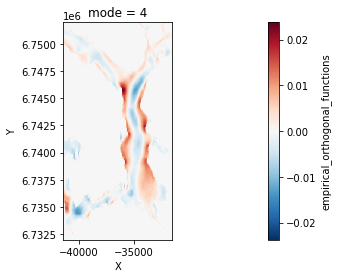

In [113]:
mode=4
eofs.isel(mode=mode).v.plot()
plt.axis('scaled')
#plt.show()

In [81]:
eig.X.min()

<xarray.DataArray 'X' ()>
array(-41444.640625)

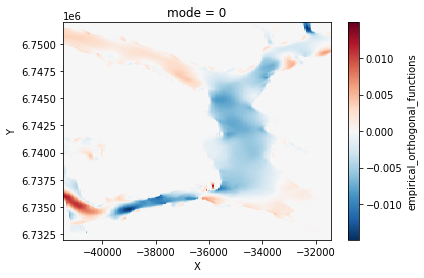

In [73]:
eofs.isel(mode=mode).v.plot()

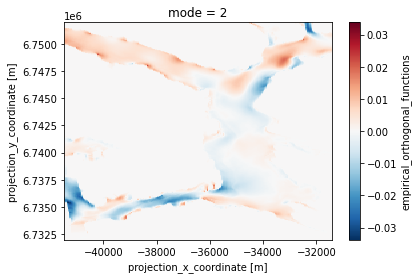

In [10]:
solverv.eofs().isel(mode=mode).plot()

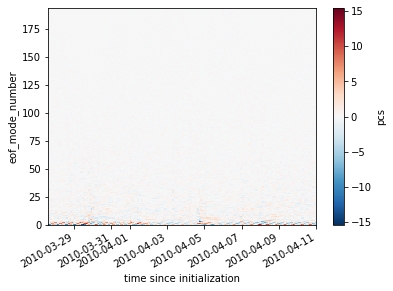

In [116]:
solver.pcs().plot(x='time')


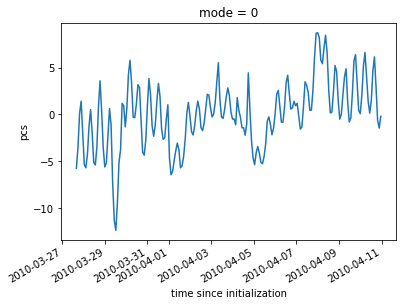

In [35]:
solverv.pcs().isel(mode=0).plot()

In [14]:
tmpu.values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [55]:

from eofs.multivariate.standard import MultivariateEof
msolver = MultivariateEof([tmpu.values, tmpv.values])


In [57]:
eofs_data1, eofs_data2 = msolver.eofs(neofs=5)

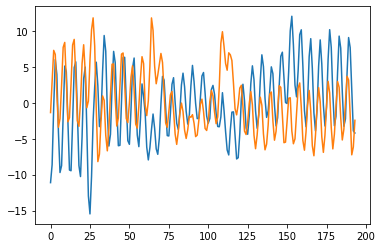

In [72]:
pcs = msolver.pcs()
np.shape(pcs)

plt.plot(pcs[:,0:2])
ts_0=pcs[:,0]

(0.0, 10.0)

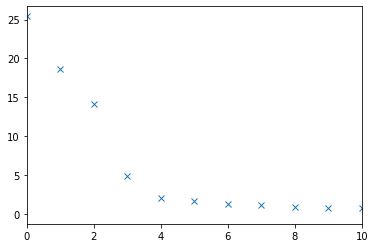

In [53]:
lambd=msolver.eigenvalues()
plt.plot(lambd,'x')
plt.xlim(0,10)

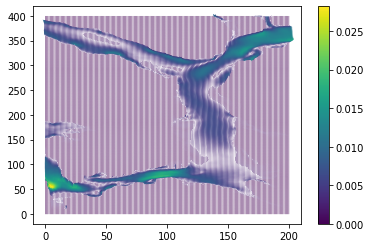

In [107]:
mode=2
plt.quiver(eofs_data1[mode],eofs_data2[mode],np.sqrt(eofs_data1[mode]**2+eofs_data2[mode]**2))
plt.colorbar()

#plt.xlim(200,250)
#plt.ylim(200,250)

(6735000.0, 6737500.0)

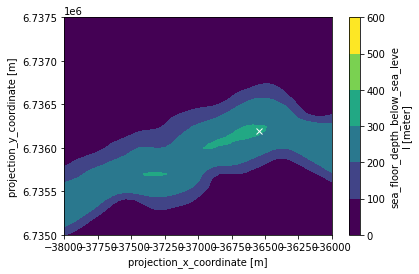

In [11]:
ix=98
iy=84
plt.clf()
vel.h.plot.contourf()
plt.plot(vel.isel(X=ix,Y=iy).X, vel.isel(X=ix,Y=iy).Y,'wx')
plt.xlim(-38000,-36000)
plt.ylim(6735000,6737500)

In [12]:
uu=xr.ufuncs.minimum(1,vel.isel(X=ix,Y=iy).u.dropna(dim='time'))
uu=xr.ufuncs.maximum(-1,uu)
uu

In [50]:
pnt=vel.isel(X=ix,Y=iy)
pnt=pnt.where(pnt.depth < pnt.h,drop=True)
pnt['speed']=np.sqrt(pnt.u**2+pnt.v**2)
angles=np.arctan2(pnt['u'],pnt['v'])
pnt['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
pnt

<xarray.Dataset>
Dimensions:           (time: 1501, depth: 23)
Coordinates:
    X                 float32 -3.654e+04
    Y                 float32 6.736e+06
  * depth             (depth) float32 1.0 3.0 5.0 10.0 ... 200.0 250.0 300.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, depth) float32 0.2377 0.1206 ... 0.01118 0.02139
    v                 (time, depth) float32 0.08277 0.06918 ... 0.01751
    h                 (depth) float64 301.0 301.0 301.0 ... 301.0 301.0 301.0
    projection_stere  (depth) float64 9.969e+36 9.969e+36 ... 9.969e+36
    land_binary_mask  (depth) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    speed             (time, depth) float32 0.2517 0.139 ... 0.01173 0.02765
    direction         (time, depth) float32 70.8 60.15 19.55 ... 107.6 50.69
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

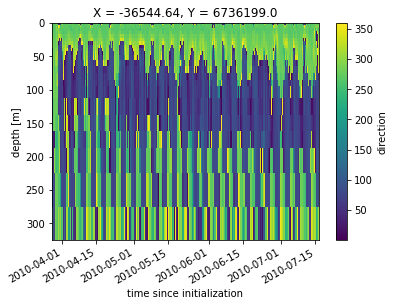

In [52]:

pnt.direction.plot(x='time',y='depth')
plt.gca().invert_yaxis()

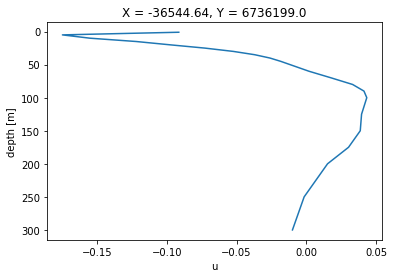

In [49]:
pnt.u.mean(dim='time').plot(y='depth')
plt.gca().invert_yaxis()

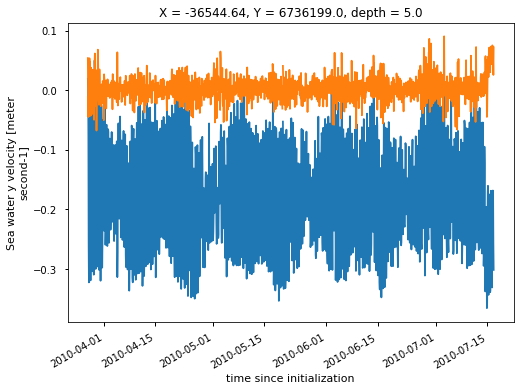

In [73]:
ein=pnt.isel(depth=2)
ein.u.plot()
ein.v.plot()


In [104]:
freq=tmpu.time.diff(dim='time').mean()/np.timedelta64(1, 'h')
freq=1/freq
infreq=freq.values
infreq

array(0.5625)

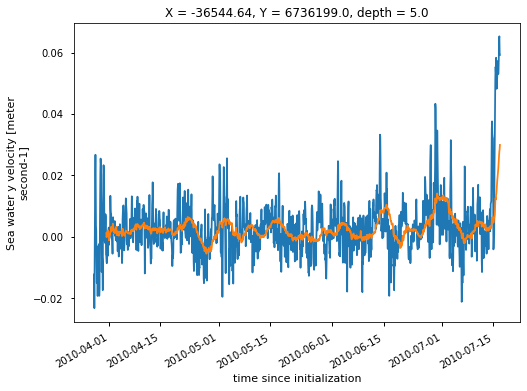

In [103]:
ein.v.interpolate_na(dim='time').rolling(time=5).mean().plot()
ein.v.interpolate_na(dim='time').rolling(time=50).mean().plot()

In [102]:
x = list(range(len(tmpu.time)))
y=ts_0
y=(y-y.mean())/y.std()
y

array([-2.209264  , -1.7142539 , -0.12098871,  1.1918148 ,  0.7799373 ,
       -0.8138958 , -1.9300195 , -1.7398924 , -0.32599792,  1.0128293 ,
        0.8542622 , -0.52392787, -1.8605782 , -1.8807766 , -0.52869856,
        0.9689724 ,  1.1280723 , -0.22080402, -1.7369614 , -2.0409665 ,
       -0.9446936 ,  0.6638378 ,  0.9829679 , -0.7157631 , -2.5773313 ,
       -3.0736914 , -2.0360403 , -0.500737  ,  0.4390933 ,  1.1196716 ,
        0.4656098 , -0.6619453 , -0.39271092,  0.8660882 ,  1.8570611 ,
        1.4246658 , -0.23140644, -1.1976385 , -0.87193054,  0.41610277,
        1.4181217 ,  1.1082686 , -0.15330435, -1.1893032 , -1.178338  ,
        0.01196737,  1.2511202 ,  1.2539897 ,  0.05098471, -1.049903  ,
       -1.1504617 , -0.20924193,  0.9568321 ,  1.2345142 ,  0.1864505 ,
       -0.8935938 , -1.2149185 , -0.46848154,  0.5188029 ,  0.17181407,
       -0.28378806, -1.2273136 , -1.5812482 , -1.2432939 , -0.7454584 ,
       -0.31321728, -0.7056467 , -1.274228  , -1.4263977 , -0.96

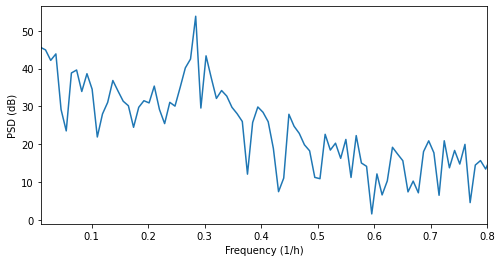

In [105]:

temp_fft = sp.fft.fft(ts_0)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fft.fftfreq(len(temp_psd), infreq)
i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0.01, 0.8)
ax.set_xlabel('Frequency (1/h)')
ax.set_ylabel('PSD (dB)')
#%%
f=abs(np.fft.fft(y))

# get the list of frequencies
num=np.size(x)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
#plt.semilogy(nspectrum)

In [131]:
1/12

0.08333333333333333

In [77]:
np.size(ts_0)

194

In [98]:

coef = solve(date2num(tmpu.time), ts_0, lat=60.0)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(tmpu.time), coef)

coef

solve: matrix prep ... solution ... done.
prep/calcs ... done.


{'name': array(['M2', 'K1', 'O1', 'M3', 'M8', 'M6', 'M4', '2MK5', '3MK7', '2SK5'],
       dtype=object),
 'aux': {'frq': array([0.0805114 , 0.04178075, 0.03873065, 0.1207671 , 0.3220456 ,
         0.2415342 , 0.1610228 , 0.20280355, 0.28331495, 0.20844741]),
  'lind': array([ 47,  20,  12,  68, 124, 105,  81,  95, 119,  98]),
  'reftime': 14702.814814814814,
  'opt': {'twodim': False,
   'equi': True,
   'conf_int': True,
   'cnstit': 'auto',
   'notrend': False,
   'prefilt': [],
   'nodsatlint': 0,
   'nodsatnone': 0,
   'gwchlint': False,
   'gwchnone': False,
   'infer': None,
   'inferaprx': 0,
   'rmin': 1,
   'method': 'ols',
   'tunrdn': 1,
   'linci': True,
   'white': False,
   'nrlzn': 200,
   'lsfrqosmp': 1,
   'nodiagn': 0,
   'diagnplots': 0,
   'diagnminsnr': 2,
   'ordercnstit': 'PE',
   'runtimedisp': 'yyy',
   'nodesatlint': False,
   'nodesatnone': False,
   'newopts': {'constit': 'auto',
    'order_constit': 'PE',
    'conf_int': 'linear',
    'method': 'ols',
    '

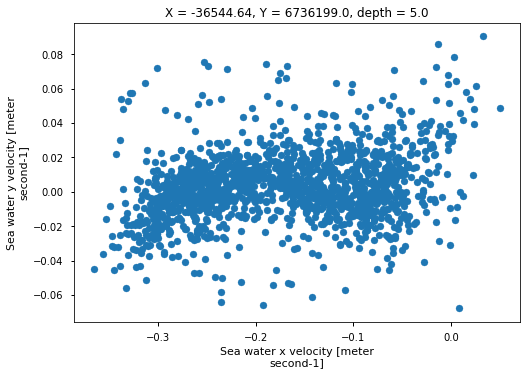

In [66]:
ein.squeeze().plot.scatter(x='u',y='v')

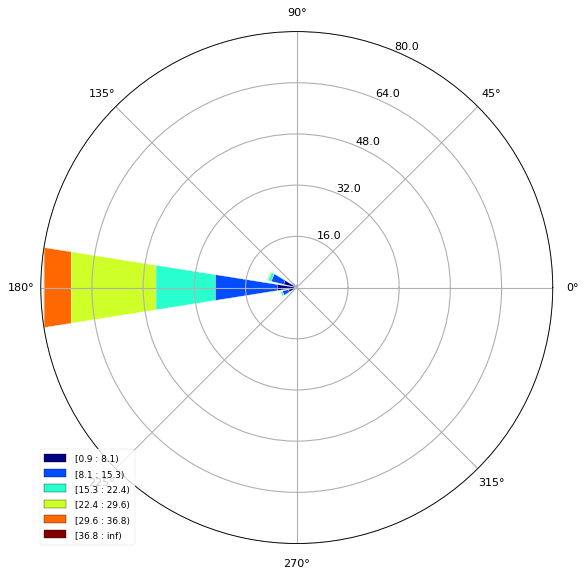

In [67]:
idepth=1
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(ein.direction.squeeze(), 100*ein.speed.squeeze(), normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

/home/guttorm/Github/FACTS/venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

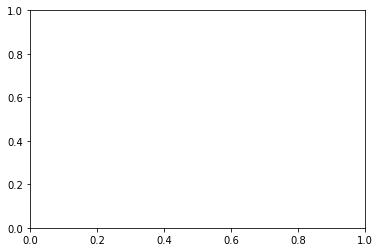

In [101]:
plt.plot(tide.values())

Text(0.5, 1.0, 'Residue')

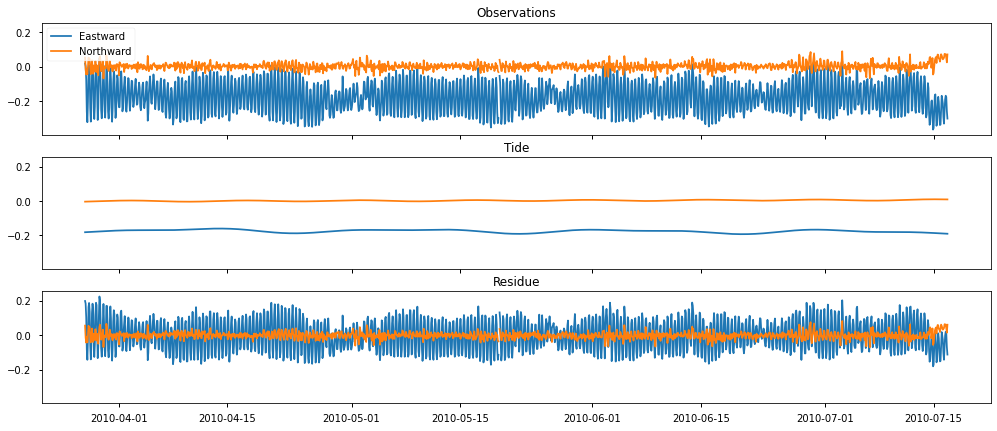

In [69]:
from matplotlib import style

style.use('seaborn-notebook')
t=tmpu.time
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,  figsize=(17, 7))

ax0.plot(t, ein.u, label='Eastward')

ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, ein.u-tide['u'])
ax2.plot(t, ein.v-tide['v'])
ax2.set_title('Residue')

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
uu=ein.v.squeeze().to_dataframe().v

uu=uu.interpolate()
uu.index[1]-uu.index[0]

Timedelta('0 days 01:46:40')

In [21]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

In [71]:

decomposition = seasonal_decompose(uu, model='additive', period=220)


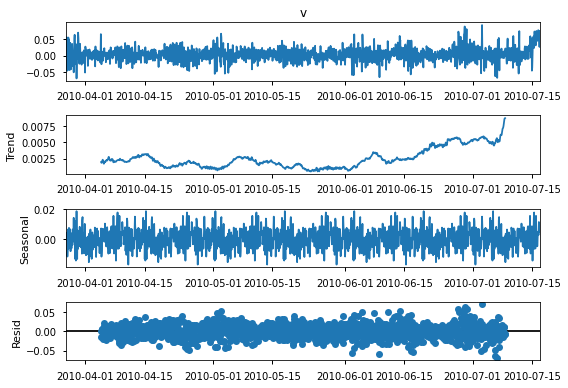

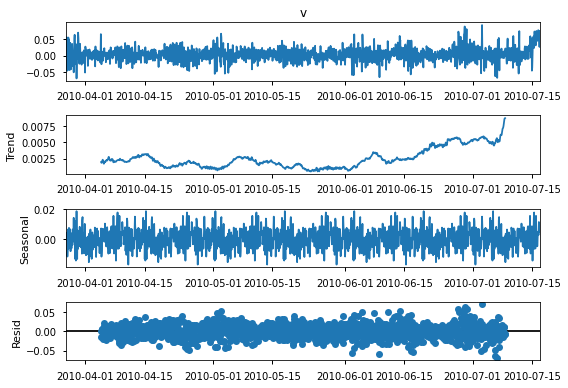

In [72]:
decomposition.plot()